Ten plik zawiera cały kod użyty do trenowania sieci, której zadaniem jest segmentacja obrazu. Obraz jest segmentowany na 12 różnych kategorii takich jak: niebo, słońce, góry, roślinność, tło, budynki, zwięrzęta, ptaki, osoby i zbędne obiekty w kadrze. Zdjęcia oznaczałem narzędziem PixelAnnotationTool. Zbiór treningowy liczy sobie ok. 100 zdjęć zebranych przeze mnie.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gc
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,BatchNormalization,Activation,MaxPooling2D,Add,Flatten,Reshape,Multiply,UpSampling2D,GlobalAveragePooling2D,Concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from glob import glob
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16,MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib.pyplot import rcParams
from tensorflow.keras import mixed_precision

rcParams['figure.figsize']=18,8

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
img_dir='C:/Users/komej/Desktop/AutoEnhancer/postprocessed/'
img_test='C:/Users/komej/Desktop/AutoEnhancer/postprocessed_test/'
mask_dir='C:/Users/komej/Desktop/AutoEnhancer/segmented2/'
mask_test='C:/Users/komej/Desktop/AutoEnhancer/segmented_test/'

Architektura sieci to DeepLabV3+ stworzona przez grupę badaczy z Google'a. Główną zaletą tej architektury jest bardzo wysoka skuteczność przy niskim koszcie obliczeniowym. Posiada kilka kluczowych cech takich jak rozszerzoną konwolucję(dilated convolution), która pomaga zrozumieć więcej kontekstu, używając przy tym tą samą liczbę parametrów. Działa to w sposób powiększania rozmiaru filtra, dodając zera w celu wypełnienia luki między parametrami. Następnie jest struktura autoencodera, szkieletem jest przetrenowana sieć ResNet50 wraz z piramidalnym próbkowaniem w dół przetwarza informacje wieloskalowe. Do tego dodane są informacje globalne, poprzez warstwę GAP. Decoder to dwie warstwy interpolacji dwuliniowej zwiększającej rozmiary 4-krotnie, gdzie po pierwszej cechy jak w sieci U-Net, są połączone z warstwą encodera, a druga poprzedzona warstwą konwolucji o rozmiarze filtra 3x3. Ostatnia warstwa ma 12 cech, tyle ile klas do segmentacji oraz funkcję aktywacyjną softmax.

In [61]:
def conv_block(inp,filters,kernel_size,dilation=1,use_bias=False):
    x=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation,kernel_initializer='he_normal',use_bias=use_bias)(inp)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x

def dilated_pyramid_pooling(inp):
    x=GlobalAveragePooling2D(keepdims=True)(inp)
    x=conv_block(x,filters=256,kernel_size=(1,1),use_bias=True)
    out_pool=UpSampling2D((inp.shape[-3]//x.shape[1],inp.shape[-2]//x.shape[2]),interpolation='bilinear')(x)
    #shape_before=K.int_shape(inp)
    #resize=tf.keras.layers.experimental.preprocessing.Resizing(*shape_before[1:3],interpolation='bilinear')(x)
    
    conv_1=conv_block(inp,filters=256,kernel_size=(1,1),dilation=1)
    conv_6=conv_block(inp,filters=256,kernel_size=(3,3),dilation=6)
    conv_12=conv_block(inp,filters=256,kernel_size=(3,3),dilation=12)
    conv_18=conv_block(inp,filters=256,kernel_size=(3,3),dilation=18)
    
    x=Concatenate(axis=-1)([out_pool,conv_1,conv_6,conv_12,conv_18])
    out=conv_block(x,filters=256,kernel_size=(1,1))
    return out


def deeplabv3plus():
    resnet50v2=tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_shape=(384,512,3))
    x=resnet50v2.get_layer('conv4_block6_2_relu').output
    x=dilated_pyramid_pooling(x)
    
    inp_a=UpSampling2D((4,4),interpolation='bilinear')(x)
    #inp_a=UpSampling2D((2,2),interpolation='bilinear')(x)
    #inp_a=conv_block(inp_a,filters=128,kernel_size=(1,1))
    #inp_a=UpSampling2D((2,2),interpolation='bilinear')(inp_a)
    
    inp_b=resnet50v2.get_layer('conv2_block3_2_relu').output
    inp_b=conv_block(inp_b,filters=48,kernel_size=(1,1))

    x=Concatenate(axis=-1)([inp_a,inp_b])
    x=conv_block(x,filters=128,kernel_size=(3,3))
    x=conv_block(x,filters=128,kernel_size=(3,3))
    x=UpSampling2D((4,4),interpolation='bilinear')(x)
    #x=conv_block(x,filters=128,kernel_size=(3,3))
    #x=UpSampling2D((2,2),interpolation='bilinear')(x)
    
    out=Conv2D(12,kernel_size=(1,1),padding='same',activation='softmax')(x)
    model=Model(resnet50v2.input,out)
    return model

In [62]:
model=deeplabv3plus()

In [63]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 390, 518, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 192, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 96, 128, 64)  16448       ['conv2_block2_out[0][0]']       
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 96, 128, 64)  256        ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 96, 128, 64)  0          ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 96, 128, 64)  36928       ['conv2_block3_1_relu[0][0]']    
          

                                                                                                  
 conv3_block2_out (Activation)  (None, 48, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 48, 64, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 48, 64, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 48, 64, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_add (Add)         (None, 24, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 24, 32, 1024  0           ['conv4_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 24, 32, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 24, 32, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block4_add (Add)         (None, 24, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 24, 32, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 24, 32, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 24, 32, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 activation_19 (Activation)     (None, 24, 32, 256)  0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_20 (Activation)     (None, 24, 32, 256)  0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 activation_21 (Activation)     (None, 24, 32, 256)  0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 24, 32, 256)  0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 24, 32, 1280  0           ['up_sampling2d_6[0][0]',        
          

In [64]:
#Funckja losowo wczytująca zdjęcia zwykłe i zdjęcia maski oraz odpowiednią je przetwarzając. 
def batch_gen(batch_size,input_path,label_path):
    while(1):
        noisy=os.listdir(input_path)
        img_batches=np.random.choice(noisy,size=batch_size)
        noisy_images=[]
        for img in img_batches:
            image=cv2.imread(input_path+img)
            image=cv2.resize(image,(512,384),interpolation=cv2.INTER_AREA)
            noisy_images.append(image)
        noisy_images=np.array(noisy_images)
        noisy_images=noisy_images.astype('float32')
        noisy_images=tf.keras.applications.resnet50.preprocess_input(noisy_images)/127.5
        noisy_images=tf.cast(noisy_images,dtype=tf.float32)
        mask_images=[]
        for img1 in img_batches:
            spli=os.path.splitext(img1)[0]
            img1=spli+'_mask'+'.png'
            mask_path=mask_dir+img1
            image1=cv2.imread(mask_path,0)
            image1=cv2.resize(image1,(512,384),interpolation=cv2.INTER_NEAREST)
            mask_images.append(image1)
        mask_images=np.array(mask_images)
        mask_images=mask_images.astype('float32')
        #Zamiana na binarną macierz klas
        mask_images=to_categorical(mask_images,num_classes=12)
        mask_images=tf.cast(mask_images,dtype=tf.float32)
    
        yield(noisy_images,mask_images)

In [65]:
def test_gen(input_path,label_path):
    noisy=os.listdir(input_path)
    masks=os.listdir(label_path)
    images=[]
    for img in noisy:
        image=cv2.imread(input_path+img)
        image=cv2.resize(image,(512,384),interpolation=cv2.INTER_AREA)
        images.append(image)
    images=np.array(images,np.float32)
    images_pr=images.copy()
    images_pr=tf.keras.applications.resnet50.preprocess_input(images_pr)/127.5
    mask_images=[]
    for img1 in masks:
        image1=cv2.imread(label_path+img1,0)
        image1=cv2.resize(image1,(512,384),interpolation=cv2.INTER_NEAREST)
        mask_images.append(image1)
    mask_images=np.array(mask_images)
    mask_images=mask_images.astype('float32')
    #Zamiana na binarną macierz klas
    mask_images=to_categorical(mask_images,num_classes=12)
    return(images_pr,mask_images,images)

Metryka jaką wykorzystuje w monitorowaniu precyzji sieci podczas trenowania to Indeks Jaccarda(IoU-Intersection over Union), daje on znacznie lepszą prezentację co do precyzji sieci niż reszta metryk. IoU mierzy liczbę pikseli wspólnych między maską docelową a przewidzianą, podzieloną przez całkowitą liczbę pikseli w obu maskach. W przypadku doboru funkcji kosztu współczynnik Sorensena(Dice Coefficient) to dokładnie to samo co wskaźnik F1(F1-score), dobrze sobie radzi ale w przypadku nierównowagi klas w zbiorze danych lepiej z tym zadaniem poradzi sobie Focal Loss, który pomaga funckji skupić się na optymalizacji trudnych przykładów,zmniejszając znaczne wagi łatwych przykładów, oraz zachować balans klas poprzez dodanie parametru wagowego alpha. Najprościej mówiąc Focal Loss to dynamicznie skalowana entropia krzyżowa.

In [66]:
def dice_coef(y_true,y_pred):
    smooth=1
    C=K.sum(K.abs(y_true*y_pred),axis=-1)
    return (2. * C + smooth) / (K.sum(K.square(y_true),-1)+K.sum(K.square(y_pred),-1)+smooth)
def dice_loss(y_true,y_pred):
    return 1.0-dice_coef(y_true,y_pred)

def iou(y_true,y_pred,smooth=1):
    intersection=K.sum(K.abs(y_true*y_pred),axis=[1,2,3])
    union=K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou=K.mean((intersection+smooth) / (union+smooth),axis=0)
    return iou

In [67]:
def focal_loss(y_true,y_pred,gamma=2.0,alpha=0.25):
    epsilon=K.epsilon()
    y_pred=K.clip(y_pred,epsilon,1.0-epsilon)
    cross_entropy=-y_true*K.log(y_pred)
    weight=alpha*y_true*K.pow((1-y_pred),gamma)
    loss=weight*cross_entropy
    loss=K.sum(loss,axis=1)
    return loss

In [90]:
class CustomDataValidation(tf.keras.callbacks.Callback):
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y

    def on_epoch_end(self, epoch, logs=None):
        result = self.model.test_on_batch(x=self.x, y=self.y, return_dict=True)
        print(' Validation:',result)
clb=CustomDataValidation(x,y)

In [69]:
#Funkcja do zmiany szybkości uczenia, wraz z zwiększającą się liczbą epok
def decay_schedule(epoch, lr):
    if (epoch % 150 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

In [167]:
model.compile(loss=focal_loss,optimizer=Adam(learning_rate=0.0001),metrics=[iou])

In [175]:
batch_size=4
epochs=20
train_l,test_l,test_e=[],[],[]
iou_train,iou_test=[],[]
batch=batch_gen(batch_size,img_dir,mask_dir)
img_t,mask_t,to_plt=test_gen(img_test,mask_test)
for e in range(1,epochs+1):
    imgs,mask=next(batch)
    #current_lr=K.eval(model.optimizer.learning_rate)
    #nlr=decay_schedule(e,current_lr)
    #K.set_value(model.optimizer.learning_rate,nlr)
    loss=model.train_on_batch(imgs,mask)
    test_loss=model.test_on_batch(img_t,mask_t)
    train_l.append(loss[0])
    iou_train.append(loss[1])
    test_l.append(test_loss[0])
    iou_test.append(test_loss[1])
    test_e.append(e)
    gc.collect()
    print('Epoch:',e)
    print('Train_Loss:',round(loss[0],4),'IoU:',round(loss[1],4))
    print('Val_Loss:',round(test_loss[0],4),'val_IoU:',round(test_loss[1],4))

Epoch: 1
Train_Loss: 0.1625 IoU: 0.737
Val_Loss: 1.0233 val_IoU: 0.74
Epoch: 2
Train_Loss: 0.1196 IoU: 0.7758
Val_Loss: 1.0235 val_IoU: 0.74
Epoch: 3
Train_Loss: 0.1111 IoU: 0.8205
Val_Loss: 1.0215 val_IoU: 0.7402
Epoch: 4
Train_Loss: 0.0795 IoU: 0.7937
Val_Loss: 1.0198 val_IoU: 0.7401
Epoch: 5
Train_Loss: 0.1212 IoU: 0.7889
Val_Loss: 1.0161 val_IoU: 0.7403
Epoch: 6
Train_Loss: 0.08 IoU: 0.8053
Val_Loss: 1.0152 val_IoU: 0.7403
Epoch: 7
Train_Loss: 0.0881 IoU: 0.7973
Val_Loss: 1.0162 val_IoU: 0.7403
Epoch: 8
Train_Loss: 0.0664 IoU: 0.8297
Val_Loss: 1.0149 val_IoU: 0.7406
Epoch: 9
Train_Loss: 0.2081 IoU: 0.741
Val_Loss: 1.0185 val_IoU: 0.7406
Epoch: 10
Train_Loss: 0.0795 IoU: 0.8046
Val_Loss: 1.0203 val_IoU: 0.7406
Epoch: 11
Train_Loss: 0.0956 IoU: 0.7977
Val_Loss: 1.0229 val_IoU: 0.7406
Epoch: 12
Train_Loss: 0.0652 IoU: 0.8248
Val_Loss: 1.0218 val_IoU: 0.7407
Epoch: 13
Train_Loss: 0.0996 IoU: 0.7967
Val_Loss: 1.0183 val_IoU: 0.7407
Epoch: 14
Train_Loss: 0.1007 IoU: 0.7982
Val_Loss: 1.01

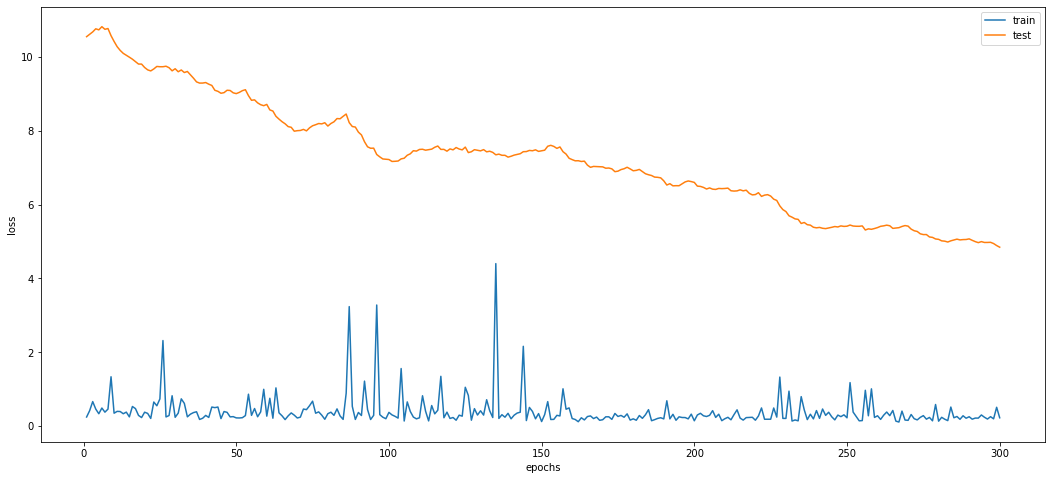

In [91]:
plt.plot(test_e,train_l,label='train')
plt.plot(test_e,test_l,label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

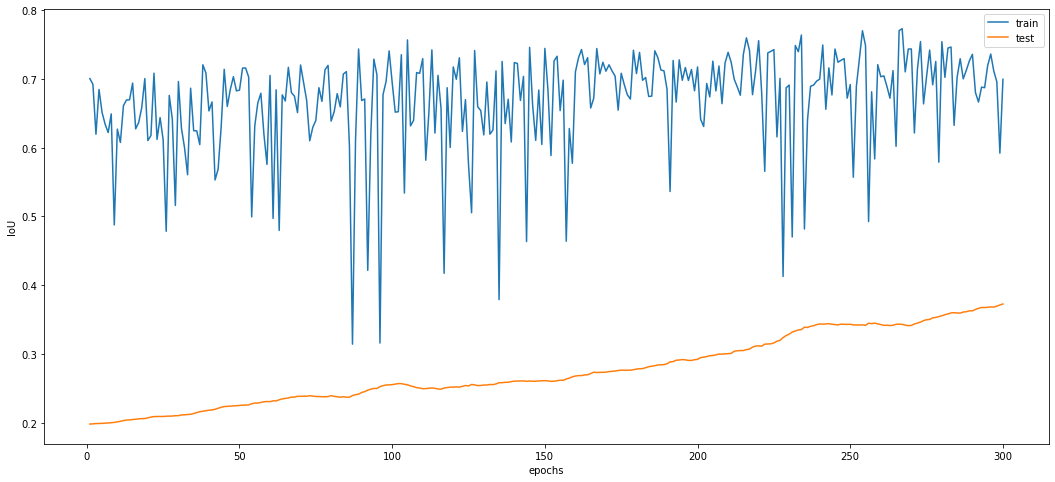

In [92]:
plt.plot(test_e,iou_train,label='train')
plt.plot(test_e,iou_test,label='test')
plt.xlabel('epochs')
plt.ylabel('IoU')
plt.legend()

Proces trenowania sieci jest bardzo czasochłonny, model potrzebuje ok. 1000 epok , aby w miare poprawnie nauczył się zaznaczać obiekty na zdjęciu. IoU na zbiorze treningowym oscyluje ok. 76%-84%, a na zbiorze testowym ok.74%. Jest to wynik całkiem w porządku jak na niewielki zbiór danych.

In [160]:
def predict_compare(plo,img_arr,mask_arr):
    plo=cv2.cvtColor(plo,cv2.COLOR_BGR2RGB)
    #test_img_in=cv2.imread(img_path)
    #test_img_in=cv2.resize(test_img_in,(512,384),interpolation=cv2.INTER_AREA)
    #test_img=test_img_in.astype('float32')
    #test_img=tf.keras.applications.resnet50.preprocess_input(test_img)/127.5
    test_img=np.expand_dims(img_arr,axis=0)
    score=model.predict(test_img)
    score=score[0,:,:,:]
    score_ar=np.argmax(score,axis=2)
    mask_arr=np.argmax(mask_arr,axis=2)
    fig,axs=plt.subplots(1,3,figsize=(20,20))
    axs[0].imshow(plo/255)
    axs[0].set_title('Input')
    axs[1].imshow(score_ar)
    axs[1].set_title('Prediction')
    axs[2].imshow(mask_arr)
    axs[2].set_title('True')

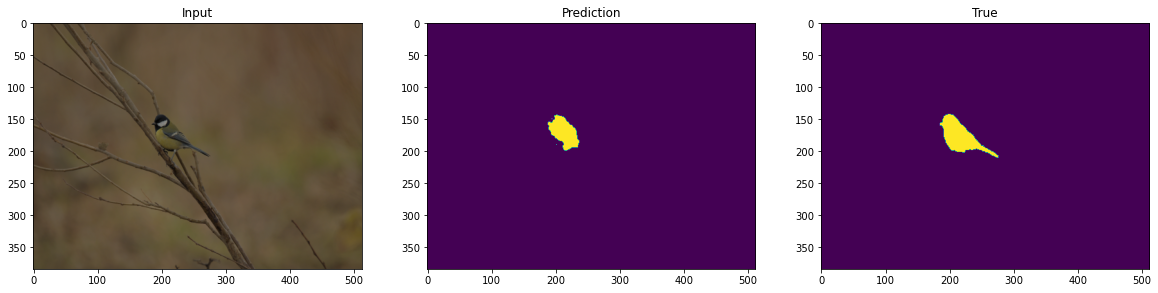

In [176]:
predict_compare(to_plt[0],img_t[0],mask_t[0])

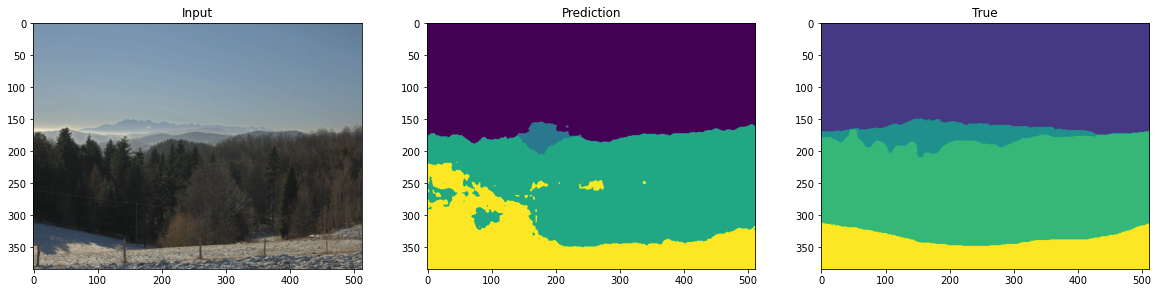

In [177]:
predict_compare(to_plt[1],img_t[1],mask_t[1])

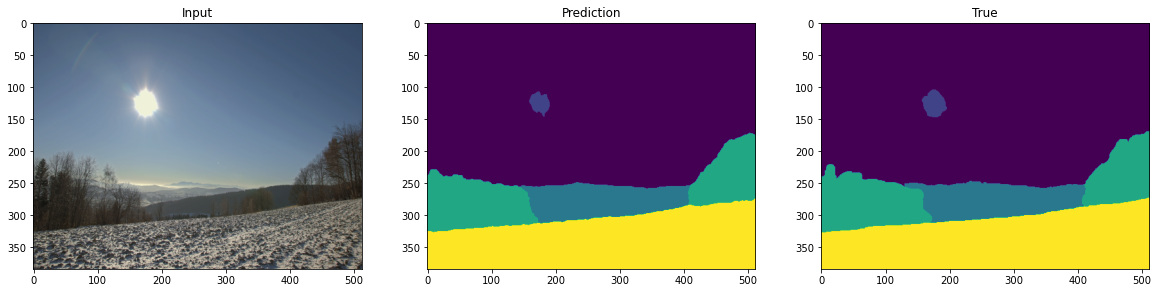

In [178]:
predict_compare(to_plt[2],img_t[2],mask_t[2])

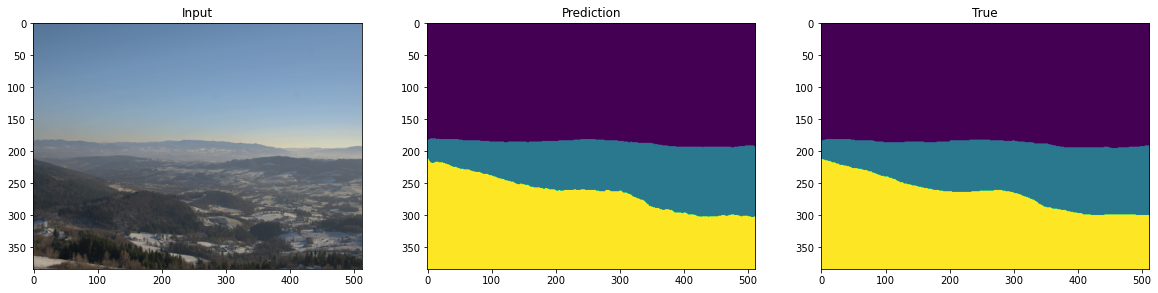

In [179]:
predict_compare(to_plt[3],img_t[3],mask_t[3])

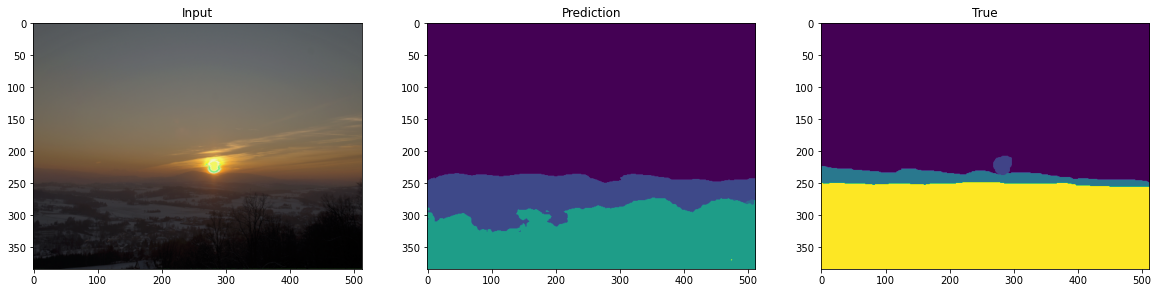

In [180]:
predict_compare(to_plt[4],img_t[4],mask_t[4])

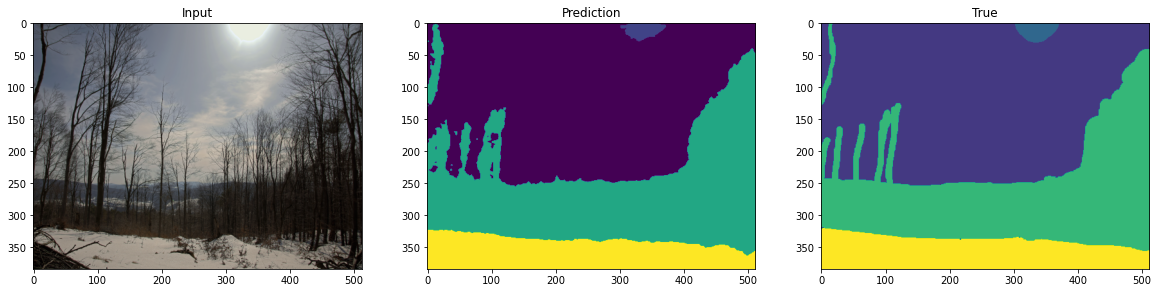

In [181]:
predict_compare(to_plt[5],img_t[5],mask_t[5])

Jak widać na porównaniu, model w wielu przypadkach radzi sobie całkiem dobrze. Na niektórych ciężko mu dobrze posegmentować odpowiednie obszary, ale myślę że zwiększenie zbioru treningowego znacznie polepszy wyniki sieci. Ewentualnie zmiana architektury sieci na lepszą i wydajniejszą.

In [187]:
model.save('C:/Users/komej/Desktop/AutoEnhancer/segm-s.h5')